In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Evaluation and HYpertuning
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score

#Model
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#Utility
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

# I Data exploration and import data

In [123]:
df=pd.read_csv('equipfails/equip_failures_training_set.csv')

In [147]:
df['sensor1_measure'][0]

76698

In [23]:
df.head(4)

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,sensor24_histogram_bin6,sensor24_histogram_bin7,sensor24_histogram_bin8,sensor24_histogram_bin9,sensor25_histogram_bin0,sensor25_histogram_bin1,sensor25_histogram_bin2,sensor25_histogram_bin3,sensor25_histogram_bin4,sensor25_histogram_bin5,sensor25_histogram_bin6,sensor25_histogram_bin7,sensor25_histogram_bin8,sensor25_histogram_bin9,sensor26_histogram_bin0,sensor26_histogram_bin1,sensor26_histogram_bin2,sensor26_histogram_bin3,sensor26_histogram_bin4,sensor26_histogram_bin5,sensor26_histogram_bin6,sensor26_histogram_bin7,sensor26_histogram_bin8,sensor26_histogram_bin9,sensor27_measure,sensor28_measure,sensor29_measure,sensor30_measure,sensor31_measure,sensor32_measure,sensor33_measure,sensor34_measure,sensor35_measure,sensor36_measure,sensor37_measure,sensor38_measure,sensor39_measure,sensor40_measure,sensor41_measure,sensor42_measure,sensor43_measure,sensor44_measure,sensor45_measure,sensor46_measure,sensor47_measure,sensor48_measure,sensor49_measure,sensor50_measure,sensor51_measure,sensor52_measure,sensor53_measure,sensor54_measure,sensor55_measure,sensor56_measure,sensor57_measure,sensor58_measure,sensor59_measure,sensor60_measure,sensor61_measure,sensor62_measure,sensor63_measure,sensor64_histogram_bin0,sensor64_histogram_bin1,sensor64_histogram_bin2,sensor64_histogram_bin3,sensor64_histogram_bin4,sensor64_histogram_bin5,sensor64_histogram_bin6,sensor64_histogram_bin7,sensor64_histogram_bin8,sensor64_histogram_bin9,sensor65_measure,sensor66_measure,sensor67_measure,sensor68_measure,sensor69_histogram_bin0,sensor69_histogram_bin1,sensor69_histogram_bin2,sensor69_histogram_bin3,sensor69_histogram_bin4,sensor69_histogram_bin5,sensor69_histogram_bin6,sensor69_histogram_bin7,sensor69_histogram_bin8,sensor69_histogram_bin9,sensor70_measure,sensor71_measure,sensor72_measure,sensor73_measure,sensor74_measure,sensor75_measure,sensor76_measure,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,42

In [12]:
df.columns

Index(['id', 'target', 'sensor1_measure', 'sensor2_measure', 'sensor3_measure',
       'sensor4_measure', 'sensor5_measure', 'sensor6_measure',
       'sensor7_histogram_bin0', 'sensor7_histogram_bin1',
       ...
       'sensor105_histogram_bin2', 'sensor105_histogram_bin3',
       'sensor105_histogram_bin4', 'sensor105_histogram_bin5',
       'sensor105_histogram_bin6', 'sensor105_histogram_bin7',
       'sensor105_histogram_bin8', 'sensor105_histogram_bin9',
       'sensor106_measure', 'sensor107_measure'],
      dtype='object', length=172)

In [11]:
df.shape

(60000, 172)

Failure:  1000  Normal:  59000


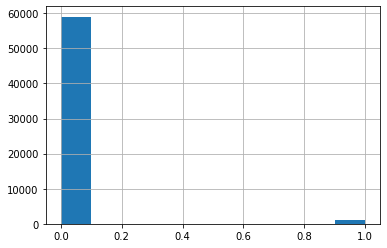

In [22]:
#Histogram of the target
print("Failure: ",  df.target.sum(), ' Normal: ', df.shape[0]-df.target.sum())
df.target.hist()

plt.show()

In [44]:
df['sensor2_measure'][0]

'na'

In [51]:
#Ratio between 'na' values and 60000 rows
nan_ratio=[]
for i in df.columns:
    foo=round((df[i]=='na').sum()/df.shape[0],2)
    nan_ratio.append(foo)

nan_ratio=pd.DataFrame({'Feature':df.columns,'na ratio':nan_ratio}).sort_values('na ratio', ascending=False)

In [57]:
nan_ratio.head()

,Feature,na ratio
80,sensor43_measure,0.82
79,sensor42_measure,0.81
78,sensor41_measure,0.80
114,sensor68_measure,0.77
3,sensor2_measure,0.77


# II Preprocessing and baseline

### 1 a) Treating 'na' with vtreat  and use xgboost, random forest, and logistic to create a baseline

In [59]:
import vtreat
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc',    # We want vtreat change variable base on this column
    outcome_target=True,  # Tell vtreat that this is actually the target
    cols_to_copy=[],   # columns that we dont want vtreat to touch
)
d_prepared = transform.fit_transform(df, df.target)

In [61]:
transform.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,id,id,clean_copy,False,True,-0.012163,0.002889,3.0,0.083333,True
1,target,target,clean_copy,False,True,1.000000,0.000000,3.0,0.083333,True
2,sensor1_measure,sensor1_measure,clean_copy,False,True,0.536978,0.000000,3.0,0.083333,True
3,sensor2_measure_logit_code,sensor2_measure,logit_code,True,True,0.013632,0.000840,169.0,0.001479,True
4,sensor2_measure_prevalence_code,sensor2_measure,prevalence_code,False,True,-0.002845,0.485825,169.0,0.001479,False


In [62]:
d_prepared.head()

,id,target,sensor1_measure,sensor2_measure_logit_code,sensor3_measure_logit_code,sensor3_measure_prevalence_code,sensor3_measure_lev_2130706432,sensor4_measure_logit_code,sensor4_measure_prevalence_code,sensor4_measure_lev_na,sensor5_measure_logit_code,sensor5_measure_prevalence_code,sensor5_measure_lev_0,sensor6_measure_logit_code,sensor6_measure_prevalence_code,sensor6_measure_lev_0,sensor7_histogram_bin0_logit_code,sensor7_histogram_bin0_prevalence_code,sensor7_histogram_bin0_lev_0,sensor7_histogram_bin1_logit_code,sensor7_histogram_bin1_prevalence_code,sensor7_histogram_bin1_lev_0,sensor7_histogram_bin2_logit_code,sensor7_histogram_bin2_prevalence_code,sensor7_histogram_bin2_lev_0,sensor7_histogram_bin3_logit_code,sensor7_histogram_bin3_prevalence_code,sensor7_histogram_bin3_lev_0,sensor7_histogram_bin4_logit_code,sensor7_histogram_bin5_logit_code,sensor7_histogram_bin6_logit_code,sensor7_histogram_bin6_prevalence_code,sensor7_histogram_bin7_logit_code,sensor7_histogram_bin7_prevalence_code,sensor7_histogram_bin7_lev_0,sensor7_histogram_bin8_logit_code,sensor7_histogram_bin8_prevalence_code,sensor7_histogram_bin8_lev_0,sensor7_histogram_bin9_logit_code,sensor7_histogram_bin9_prevalence_code,sensor7_histogram_bin9_lev_0,sensor8_measure_logit_code,sensor8_measure_prevalence_code,sensor9_measure_logit_code,sensor9_measure_prevalence_code,sensor9_measure_lev_0,sensor10_measure_logit_code,sensor10_measure_prevalence_code,sensor10_measure_lev_0,sensor11_measure_logit_code,sensor11_measure_prevalence_code,sensor11_measure_lev_0,sensor12_measure_logit_code,sensor12_measure_prevalence_code,sensor12_measure_lev_0,sensor13_measure_logit_code,sensor13_measure_prevalence_code,sensor13_measure_lev_0,sensor14_measure_logit_code,sensor14_measure_prevalence_code,sensor15_measure_logit_code,sensor15_measure_prevalence_code,sensor16_measure_logit_code,sensor16_measure_prevalence_code,sensor17_measure_logit_code,sensor17_measure_prevalence_code,sensor18_measure_logit_code,sensor18_measure_prevalence_code,sensor18_measure_lev_0,sensor19_measure_logit_code,sensor19_measure_prevalence_code,sensor19_measure_lev_0,sensor20_measure_logit_code,sensor20_measure_prevalence_code,sensor20_measure_lev_0,sensor21_measure_logit_code,sensor21_measure_prevalence_code,sensor21_measure_lev_0,sensor22_measure_logit_code,sensor22_measure_prevalence_code,sensor23_measure_logit_code,sensor23_measure_prevalence_code,sensor24_histogram_bin0_logit_code,sensor24_histogram_bin0_prevalence_code,sensor24_histogram_bin0_lev_0,sensor24_histogram_bin1_logit_code,sensor24_histogram_bin1_prevalence_code,sensor24_histogram_bin1_lev_0,sensor24_histogram_bin2_logit_code,sensor24_histogram_bin2_prevalence_code,sensor24_histogram_bin2_lev_0,sensor24_histogram_bin3_logit_code,sensor24_histogram_bin3_prevalence_code,sensor24_histogram_bin3_lev_0,sensor24_histogram_bin4_logit_code,sensor24_histogram_bin4_prevalence_code,sensor24_histogram_bin4_lev_0,sensor24_histogram_bin5_logit_code,sensor24_histogram_bin5_prevalence_code,sensor24_histogram_bin5_lev_0,sensor24_histogram_bin6_logit_code,sensor24_histogram_bin7_logit_code,sensor24_histogram_bin7_prevalence_code,sensor24_histogram_bin7_lev_0,sensor24_histogram_bin8_logit_code,sensor24_histogram_bin8_prevalence_code,sensor24_histogram_bin9_logit_code,sensor24_histogram_bin9_prevalence_code,sensor24_histogram_bin9_lev_0,sensor25_histogram_bin0_logit_code,sensor25_histogram_bin1_logit_code,sensor25_histogram_bin1_prevalence_code,sensor25_histogram_bin2_logit_code,sensor25_histogram_bin2_prevalence_code,sensor25_histogram_bin3_logit_code,sensor25_histogram_bin3_prevalence_code,sensor25_histogram_bin4_logit_code,sensor25_histogram_bin5_logit_code,sensor25_histogram_bin5_prevalence_code,sensor25_histogram_bin6_logit_code,sensor25_histogram_bin7_logit_code,sensor25_histogram_bin7_prevalence_code,sensor25_histogram_bin7_lev_0,sensor25_histogram_bin8_logit_code,sensor25_histogram_bin8_prevalence_code,sensor25_histogram_bin8_lev_0,sensor25_histo

### 1 b) Base line

In [66]:
#Prepare 
X=d_prepared.drop(['id','target'],axis=1)
y=d_prepared.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [78]:
start=time.time()
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

print(time.time()-start)

xgb=XGBClassifier()
xgb.fit(X_train.values,y_train)

print(time.time()-start)

lr=LogisticRegression()
lr.fit(X_train,y_train)

print(time.time()-start)

2.660910129547119
84.23141098022461
89.25578594207764


In [80]:
rfc_score=f1_score(rfc.predict(X_test),y_test)
xgb_score=f1_score(xgb.predict(X_test.values),y_test)
lr_score=f1_score(lr.predict(X_test),y_test)

In [81]:
print(rfc_score,xgb_score,lr_score)

0.6844660194174758 0.735632183908046 0.5117493472584855


### 2) a) Treating 'na' with MANUALLY  and use xgboost, random forest, and logistic to create a baseline

In [82]:
df.head()

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,sensor24_histogram_bin6,sensor24_histogram_bin7,sensor24_histogram_bin8,sensor24_histogram_bin9,sensor25_histogram_bin0,sensor25_histogram_bin1,sensor25_histogram_bin2,sensor25_histogram_bin3,sensor25_histogram_bin4,sensor25_histogram_bin5,sensor25_histogram_bin6,sensor25_histogram_bin7,sensor25_histogram_bin8,sensor25_histogram_bin9,sensor26_histogram_bin0,sensor26_histogram_bin1,sensor26_histogram_bin2,sensor26_histogram_bin3,sensor26_histogram_bin4,sensor26_histogram_bin5,sensor26_histogram_bin6,sensor26_histogram_bin7,sensor26_histogram_bin8,sensor26_histogram_bin9,sensor27_measure,sensor28_measure,sensor29_measure,sensor30_measure,sensor31_measure,sensor32_measure,sensor33_measure,sensor34_measure,sensor35_measure,sensor36_measure,sensor37_measure,sensor38_measure,sensor39_measure,sensor40_measure,sensor41_measure,sensor42_measure,sensor43_measure,sensor44_measure,sensor45_measure,sensor46_measure,sensor47_measure,sensor48_measure,sensor49_measure,sensor50_measure,sensor51_measure,sensor52_measure,sensor53_measure,sensor54_measure,sensor55_measure,sensor56_measure,sensor57_measure,sensor58_measure,sensor59_measure,sensor60_measure,sensor61_measure,sensor62_measure,sensor63_measure,sensor64_histogram_bin0,sensor64_histogram_bin1,sensor64_histogram_bin2,sensor64_histogram_bin3,sensor64_histogram_bin4,sensor64_histogram_bin5,sensor64_histogram_bin6,sensor64_histogram_bin7,sensor64_histogram_bin8,sensor64_histogram_bin9,sensor65_measure,sensor66_measure,sensor67_measure,sensor68_measure,sensor69_histogram_bin0,sensor69_histogram_bin1,sensor69_histogram_bin2,sensor69_histogram_bin3,sensor69_histogram_bin4,sensor69_histogram_bin5,sensor69_histogram_bin6,sensor69_histogram_bin7,sensor69_histogram_bin8,sensor69_histogram_bin9,sensor70_measure,sensor71_measure,sensor72_measure,sensor73_measure,sensor74_measure,sensor75_measure,sensor76_measure,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,42

In [159]:
#4 ways to replace nan
#First is drop na when na_ratio is > than the first threshold
#Second is replaced na by -1 if na_ratio between the 2 threshold
#Third is replaced na by mode if na_ratio < the lower threshold and the mode has to be greater than mode_threshold
#Lastly, replaced na by median

def na(df, thresholds=[0.7,0.4],mode_threshold=20000):
    for i in df.columns:
        na_ratio=round((df[i]=='na').sum()/df.shape[0],2)
        value_counts=df[i].value_counts()
        if na_ratio>thresholds[0]:
            df=df.drop(i,axis=1)  
        elif (na_ratio>=thresholds[1]) & (na_ratio<=thresholds[0]):
            df[i]=df[i].replace('na', -1)
        elif (na_ratio<thresholds[1]) & (value_counts.values[0]>mode_threshold) & (value_counts.index[0]!='na') :
            df[i]=df[i].replace('na',value_counts.index[0])
        else:
            median=np.median([float(j) for j in df[i] if j!='na'])
            df[i]=df[i].replace('na',median)
            
    return df

In [161]:
#Check if there is any 'na' left
df_new=na(df)
for i in df_new.columns:
    if (df_new[i]=='na').sum()>0:
        print(i)

In [162]:
df_new.head()

,id,target,sensor1_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,sensor24_histogram_bin6,sensor24_histogram_bin7,sensor24_histogram_bin8,sensor24_histogram_bin9,sensor25_histogram_bin0,sensor25_histogram_bin1,sensor25_histogram_bin2,sensor25_histogram_bin3,sensor25_histogram_bin4,sensor25_histogram_bin5,sensor25_histogram_bin6,sensor25_histogram_bin7,sensor25_histogram_bin8,sensor25_histogram_bin9,sensor26_histogram_bin0,sensor26_histogram_bin1,sensor26_histogram_bin2,sensor26_histogram_bin3,sensor26_histogram_bin4,sensor26_histogram_bin5,sensor26_histogram_bin6,sensor26_histogram_bin7,sensor26_histogram_bin8,sensor26_histogram_bin9,sensor27_measure,sensor28_measure,sensor29_measure,sensor30_measure,sensor31_measure,sensor32_measure,sensor33_measure,sensor34_measure,sensor35_measure,sensor36_measure,sensor37_measure,sensor38_measure,sensor44_measure,sensor45_measure,sensor46_measure,sensor47_measure,sensor48_measure,sensor49_measure,sensor50_measure,sensor51_measure,sensor52_measure,sensor53_measure,sensor54_measure,sensor55_measure,sensor56_measure,sensor57_measure,sensor58_measure,sensor59_measure,sensor60_measure,sensor61_measure,sensor62_measure,sensor63_measure,sensor64_histogram_bin0,sensor64_histogram_bin1,sensor64_histogram_bin2,sensor64_histogram_bin3,sensor64_histogram_bin4,sensor64_histogram_bin5,sensor64_histogram_bin6,sensor64_histogram_bin7,sensor64_histogram_bin8,sensor64_histogram_bin9,sensor65_measure,sensor66_measure,sensor67_measure,sensor69_histogram_bin0,sensor69_histogram_bin1,sensor69_histogram_bin2,sensor69_histogram_bin3,sensor69_histogram_bin4,sensor69_histogram_bin5,sensor69_histogram_bin6,sensor69_histogram_bin7,sensor69_histogram_bin8,sensor69_histogram_bin9,sensor70_measure,sensor71_measure,sensor72_measure,sensor73_measure,sensor74_measure,sensor75_measure,sensor76_measure,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1,0,76698,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1

In [163]:
#Baseline manually
X=df_new.drop(['id','target'],axis=1)
y=df_new.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

start=time.time()
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

print(time.time()-start)

xgb=XGBClassifier()
xgb.fit(X_train.values,y_train)

print(time.time()-start)

lr=LogisticRegression()
lr.fit(X_train,y_train)

print(time.time()-start)

rfc_score=f1_score(rfc.predict(X_test),y_test)
xgb_score=f1_score(xgb.predict(X_test.values),y_test)
lr_score=f1_score(lr.predict(X_test),y_test)

print(rfc_score,xgb_score,lr_score)

4.850590944290161
50.74992299079895
56.53799867630005
0.7483588621444202 0.7549668874172185 0.05860805860805861


**Conclusion:**: manually treating na is better

# III Model

### 1) Use cross validation to choose the best model

In [181]:
#Evaluating with k-cross validation to see which model is the best 
from sklearn.model_selection import cross_val_score
rfc=RandomForestClassifier()
xgb=XGBClassifier()
lr=LogisticRegression()
rfc_score = cross_val_score(rfc, X, y, cv=3, scoring='f1')
xgb_score = cross_val_score(xgb, X.values, y, cv=3, scoring='f1')
lr_score = cross_val_score(lr, X, y, cv=3, scoring='f1')

In [183]:
print(rfc_score.mean(),rfc_score.std())
print(xgb_score.mean(),xgb_score.std())
print(lr_score.mean(),lr_score.std())

0.7254848005820449 0.016751212433204717
0.7669742207185349 0.03339953200507656
0.2741611367698324 0.25254151194123753


**Conclusion:** Hence, xgboost is better than the other models.

### 2) Hypertuning the `na` function

In [173]:
#Tuning treating na
df_new=na(df,[0.5,0.4], 10000)
X=df_new.drop(['id','target'],axis=1)
y=df_new.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
xgb=XGBClassifier()
xgb.fit(X_train.values,y_train)
xgb_score=f1_score(xgb.predict(X_test.values),y_test)
print(xgb_score)

0.7427293064876956


* [0.7,0.1], 6000  -> 0.729
* [0.7,0.1], 30000  -> 0.733
* [0.7,0.4], 30000  -> 0.755
* [0.7,0.5],30000 -> 0.763
* [0.7,0.6],30000 -> 0.763
* [0.7,0.7],30000 -> 0.75

* [0.6,0.4],30000 -> 0.744
* [0.5,0.4],30000 -> 0.7444
* [0.5,0.4], 10000 -> 0.742

**Conclusion:** [0.7,0.5],30000 -> 0.763 give the best result

### 3) Hypertuning xgboost parameter with gridsearch

In [190]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [187]:
#Hypertuning xgb
df_new=na(df,[0.7,0.5],30000)
X=df_new.drop(['id','target'],axis=1)
y=df_new.target

xgb=XGBClassifier()
param_dist = {"max_depth": [3,4],
              "n_estimators":[100,200],
              }
grid_search = GridSearchCV(xgb, param_grid=param_dist, cv=3, scoring='f1')

In [191]:
# grid_search.fit(X.values, y.values)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time.time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)

GridSearchCV took 3289.85 seconds for 4 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.803 (std: 0.014)
Parameters: {'max_depth': 4, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.798 (std: 0.023)
Parameters: {'max_depth': 3, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.776 (std: 0.019)
Parameters: {'max_depth': 4, 'n_estimators': 100}



GridSearchCV took 3289.85 seconds for 4 candidate parameter settings.

Model with rank: 1
Mean validation score: 0.803 (std: 0.014)
Parameters: {'max_depth': 4, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.798 (std: 0.023)
Parameters: {'max_depth': 3, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.776 (std: 0.019)
Parameters: {'max_depth': 4, 'n_estimators': 100}

# IV) Submission

In [205]:
#Prepare X test
test=pd.read_csv('equipfails/equip_failures_test_set.csv')
sample=pd.read_csv('equipfails/sample_submission.csv')

df_train=na(df,[0.7,0.5],30000)
X=df_new.drop(['id','target'],axis=1)

id_=test['id']
df_test=test.drop(['id'],axis=1)
df_test=na(df_test,[0.7,0.5],30000)

df_test=df_test[X.columns] #Make sure that they have the same columns and the columns are arranged the same

In [200]:
# Training the model
y=df_new.target

xgb=XGBClassifier(max_depth= 4, n_estimators= 200)
xgb.fit(X.values,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [206]:
#Predict the test set and submit
prediction=xgb.predict(df_test.values)

In [213]:
sample.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1


In [215]:
len(prediction)

16001

In [221]:
submission=pd.DataFrame({'id':id_, 'target': prediction})
submission.target.value_counts()

0    15702
1      299
Name: target, dtype: int64

In [222]:
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [223]:
submission.to_csv("first_submission.csv", index=False)